In [1]:
import sys
sys.path.append("../")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import RandomWalkMixtureDiffusionExperiment
from models import RandomWalkMixtureDiffusion
from likelihoods import sample_random_walk_mixture_diffusion_process

C:\Users\selin\anaconda3\Lib\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = False
FIT_MODEL = True
POSTERIOR_RESIMULATION = True

# Neural Experiment

In [3]:
model = RandomWalkMixtureDiffusion()

INFO:root:Performing 2 pilot runs with the random_walk_mixture_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 100, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 100, 4)
INFO:root:Shape of shared_prior_draws batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [4]:
neural_experiment = RandomWalkMixtureDiffusionExperiment(model, checkpoint_path="../checkpoints/2afc_task_mixture_ddm")

INFO:root:Loaded loss history from ../checkpoints/2afc_task_mixture_ddm\history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/2afc_task_mixture_ddm\ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Training

In [5]:
if TRAIN_NETWORKS:
    history = neural_experiment.run()
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

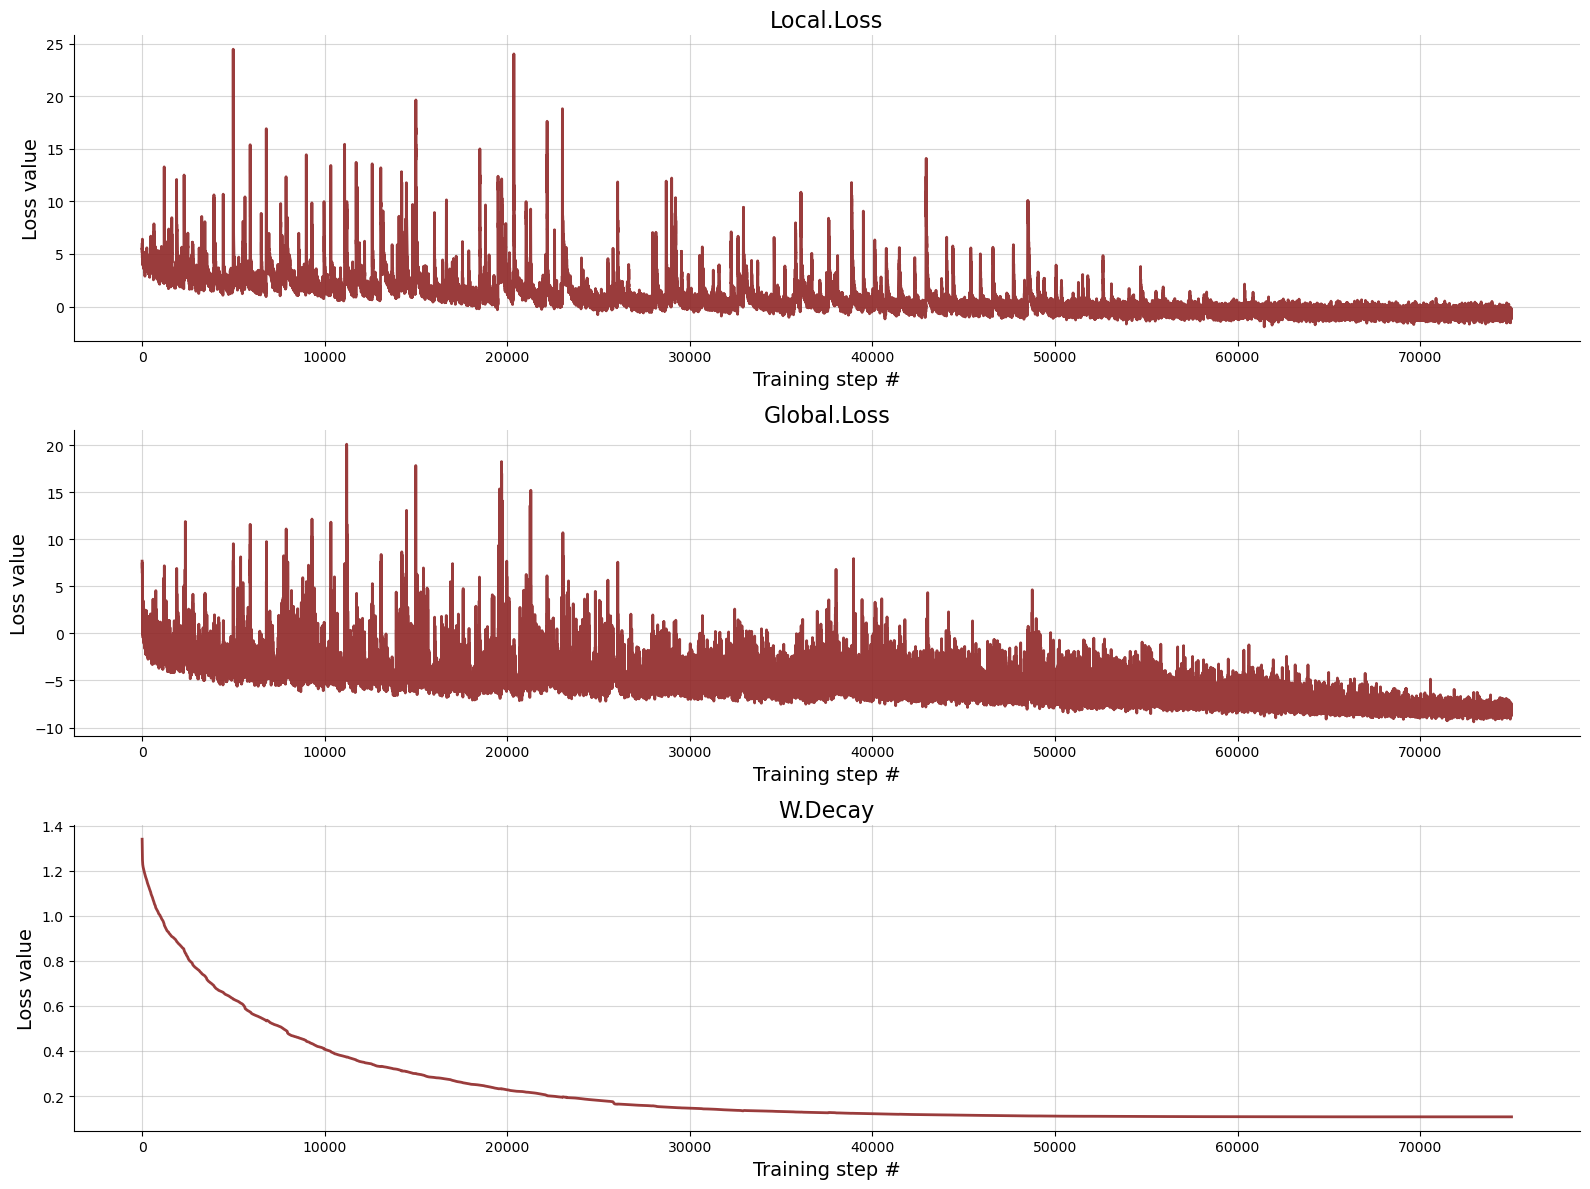

In [6]:
f = beef.diagnostics.plot_losses(history)

### Simulation-based Calibration

In [210]:
NUM_SBC_SIMULATIONS = 100
NUM_SBC_POST_SAMPLES = 1000
NUM_OBS = 100

In [211]:
model = RandomWalkMixtureDiffusion()
exp = RandomWalkMixtureDiffusionExperiment(model, checkpoint_path="../checkpoints/2afc_task_mixture_ddm") # loads trained network automatically
sim_data = model.generate(batch_size=NUM_SBC_SIMULATIONS) # simulates synthetic data sets - should be 100

INFO:root:Performing 2 pilot runs with the random_walk_mixture_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 100, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 100, 4)
INFO:root:Shape of shared_prior_draws batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/2afc_task_mixture_ddm\history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/2afc_task_mixture_ddm\ckpt-75
INFO:root:Performing a consistency check with provided com

In [212]:
configured_sim_data = model.configure(sim_data) 
true_hyper_params = sim_data['hyper_prior_draws']
true_local_params = sim_data['local_prior_draws']
true_shared_params = sim_data['shared_prior_draws']

In [213]:
from tqdm import tqdm

In [214]:
sbc_data = configured_sim_data['summary_conditions']
global_posteriors_z = np.zeros((NUM_SBC_SIMULATIONS, NUM_SBC_POST_SAMPLES, 6))
local_posteriors_z = np.zeros((NUM_SBC_SIMULATIONS, NUM_OBS, NUM_SBC_POST_SAMPLES, 4)) 

# separate handling for each data set
for i in tqdm(range(NUM_SBC_SIMULATIONS)):
    posterior_samples = exp.amortizer.sample(
        {'summary_conditions': sbc_data[i:i+1]},
        n_samples=NUM_SBC_POST_SAMPLES,
    )
    global_posteriors_z[i] = posterior_samples['global_samples'] # 6 parameters: 4 hyper, 2 shared
    local_posteriors_z[i] = posterior_samples['local_samples']
   
# samples_dict : dict
# A dictionary with keys `global_samples` and `local_samples`
# Local samples will hold an array-like of shape (num_replicas, num_samples, num_local)
# and global samples will hold an array-like of shape (num_samples, num_hyper + num_shared),
# if optional shared parameters are present, otherwise (num_samples, num_hyper)

100%|██████████████████████████████████████████| 100/100 [19:58<00:00, 11.98s/it]


In [215]:
local_params = local_posteriors_z * model.local_prior_stds + model.local_prior_means
hyper_params = global_posteriors_z[:, :, 0:4] * model.hyper_prior_std + model.hyper_prior_mean
shared_params = global_posteriors_z[:, :, 4:]

#### Calibration of Global Parameters

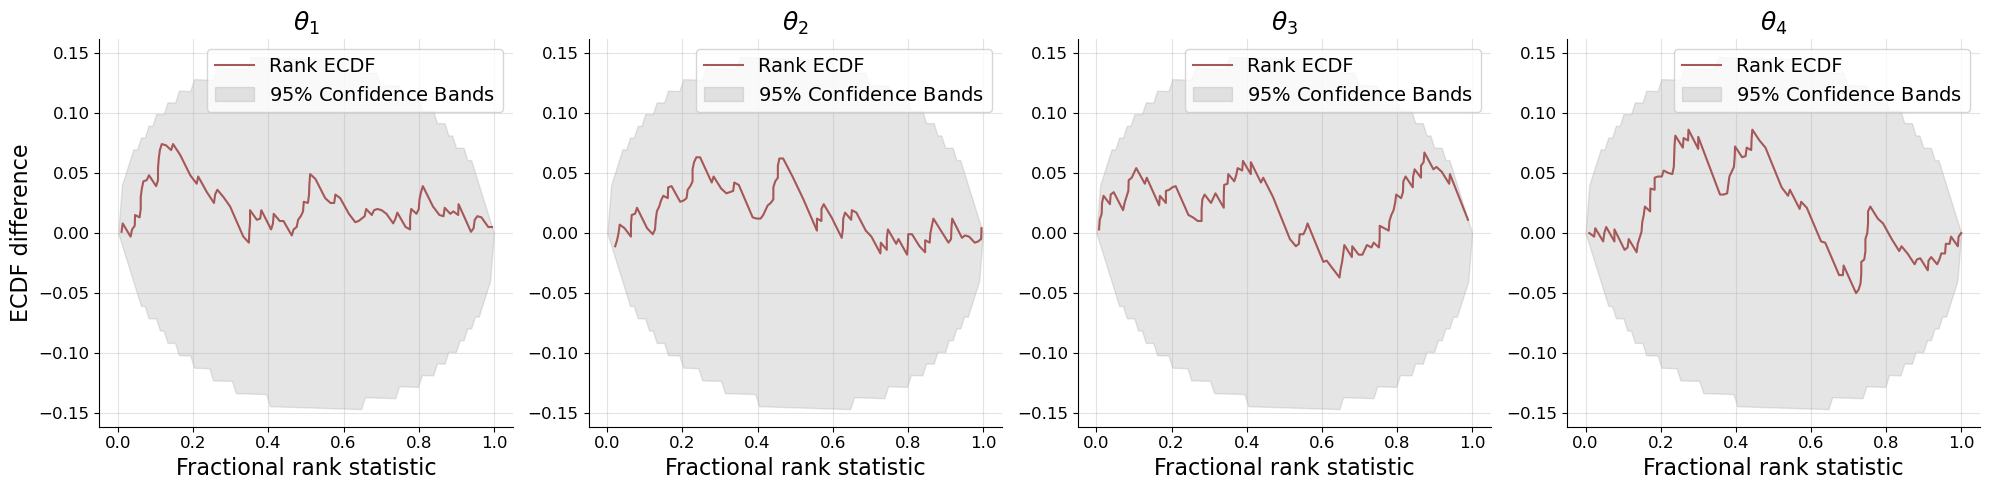

In [216]:
f = beef.diagnostics.plot_sbc_ecdf(
        hyper_params,
        true_hyper_params,
        difference=True 
    )
plt.savefig("../plots/sbc_ecdf_hyper_02.png")

#### Calibration of Shared Parameters

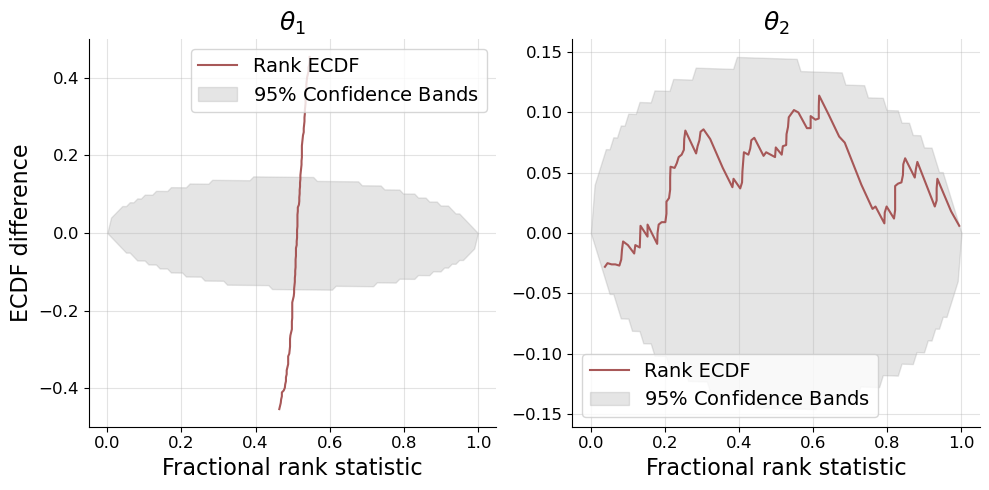

In [217]:
f = beef.diagnostics.plot_sbc_ecdf(
        shared_params,
        true_shared_params,
        difference=True 
    )
plt.savefig("../plots/sbc_ecdf_shared_02.png")

#### Calibration of Local Parameters

In [218]:
local_calibration_error = np.zeros((NUM_OBS, 4))
for i in tqdm(range(NUM_OBS)):
    local_calibration_error[i] = beef.computational_utilities.posterior_calibration_error(
        local_params[:, i],
        true_local_params[:, i]
    )

100%|██████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


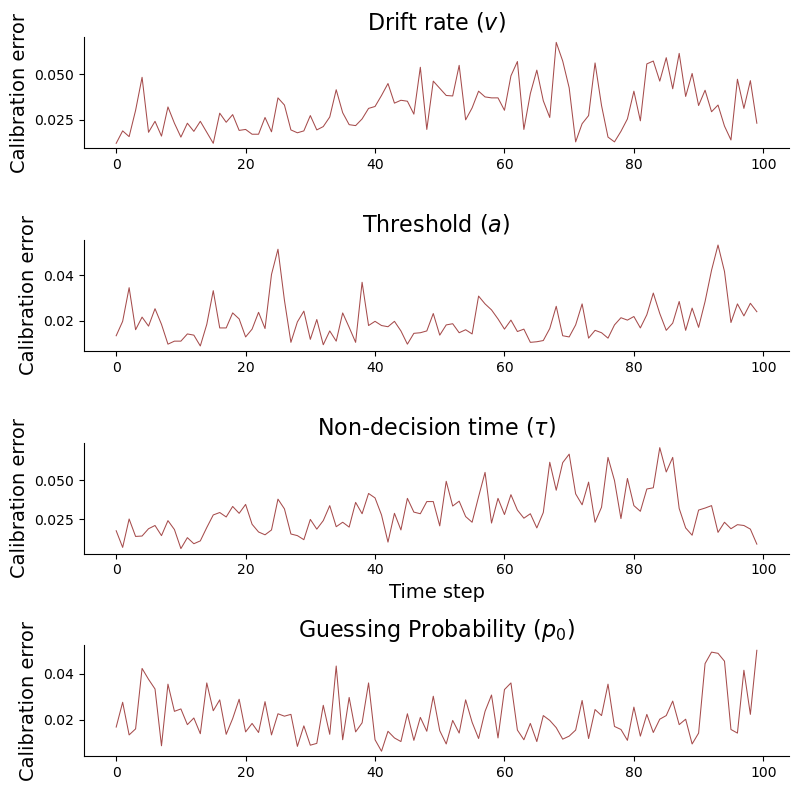

In [219]:
LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time', 'Guessing Probability']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau', r'p_0']
f, axarr = plt.subplots(4, 1, figsize=(8, 8))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        local_calibration_error[:, i],
        linewidth=0.75, color='maroon', alpha=0.7
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=16)
    ax.set_ylabel("Calibration error", fontsize=14)
    if i == 2:
        ax.set_xlabel("Time step", fontsize=14)
sns.despine()
f.tight_layout()
plt.savefig("../plots/local_calibration_error_02.png")

### Parameter Recovery

#### Parameter Recovery of Local Parameters

In [237]:
validation_sim = model.generate(1)
post_samples = exp.amortizer.sample(model.configure(validation_sim), 1000)

In [221]:
from scipy.stats import median_abs_deviation

In [238]:
local_post = post_samples['local_samples'] * model.local_prior_stds + model.local_prior_means
true_params = validation_sim['local_prior_draws'][0]
post_median = np.median(local_post, axis=1)
post_mad = median_abs_deviation(local_post, axis=1)

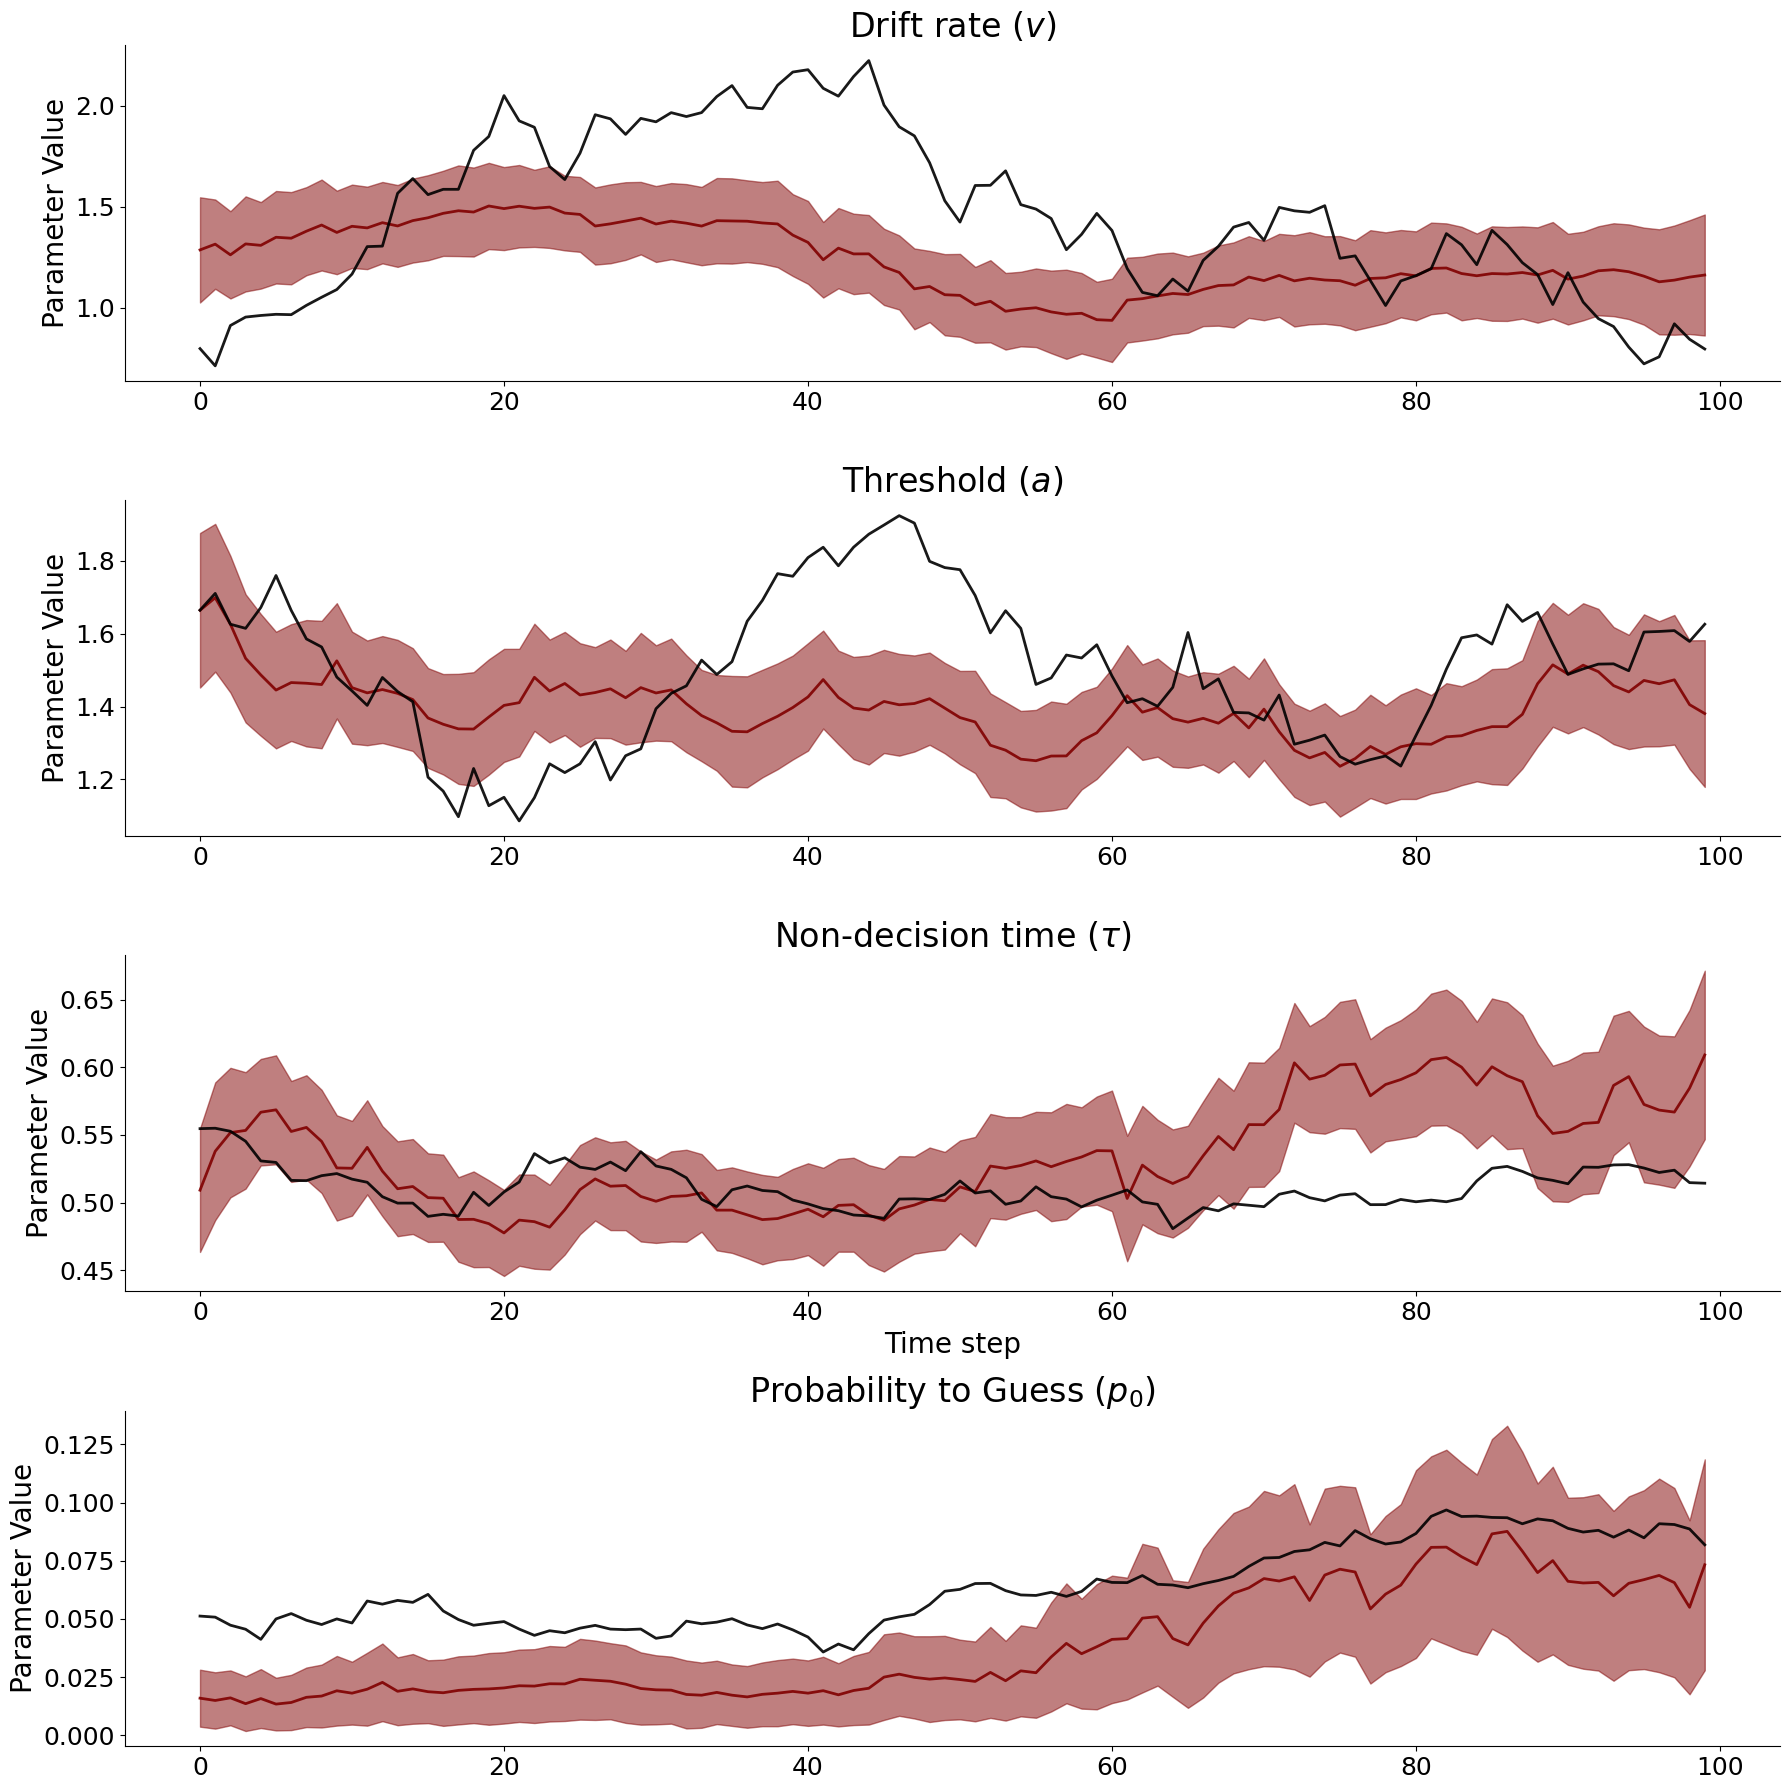

In [239]:
fig, axarr = plt.subplots(4, 1, figsize=(18, 18))
for i, ax in enumerate(axarr.flat):
    # parameter trajectory
    ax.plot(
        range(NUM_OBS),
        post_median[:, i], 
        color='maroon', alpha=0.9, lw=2, label="Posterior median"
        )
    ax.fill_between(
        range(NUM_OBS),
        post_median[:, i] - post_mad[:, i],
        post_median[:, i] + post_mad[:, i],
        color='maroon', alpha=0.5, label="Posterior MAD"
        )
    ax.plot(
        range(NUM_OBS),
        true_params[:, i], 
        color='black', alpha=0.9, lw=2, label="Ground truth"
        )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=24)
    ax.set_ylabel("Parameter Value", fontsize=20)
    if i == 2:
        ax.set_xlabel("Time step", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

sns.despine()
fig.tight_layout()
plt.savefig("../plots/local_param_recovery_02.png")

#### Local Parameter Recovery at Specific Timepoints

In [224]:
from sklearn.metrics import r2_score

In [225]:
TIME_POINTS = np.array([10, 25, 75, 100]) - 1
param_names = [r'Drift rate ($v$)', r'Threshold ($a$)', r'Non-decision time ($\tau$)', r'Probability to Guess ($\p_0$)']

In [226]:
true_local_params.shape

(100, 100, 4)

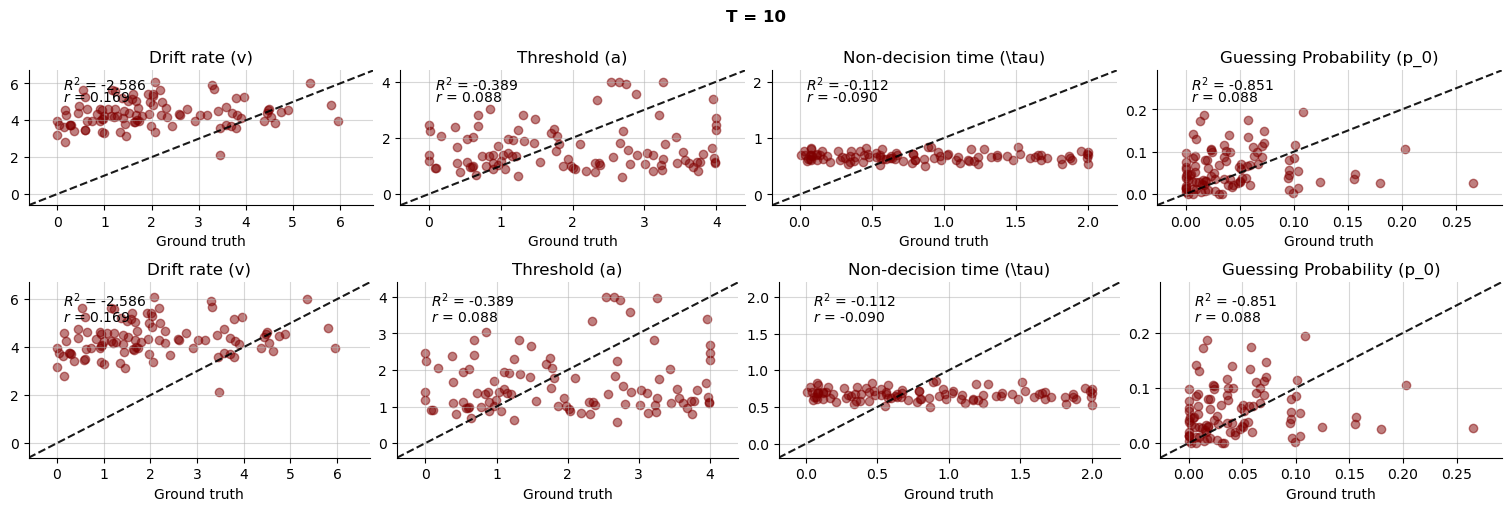

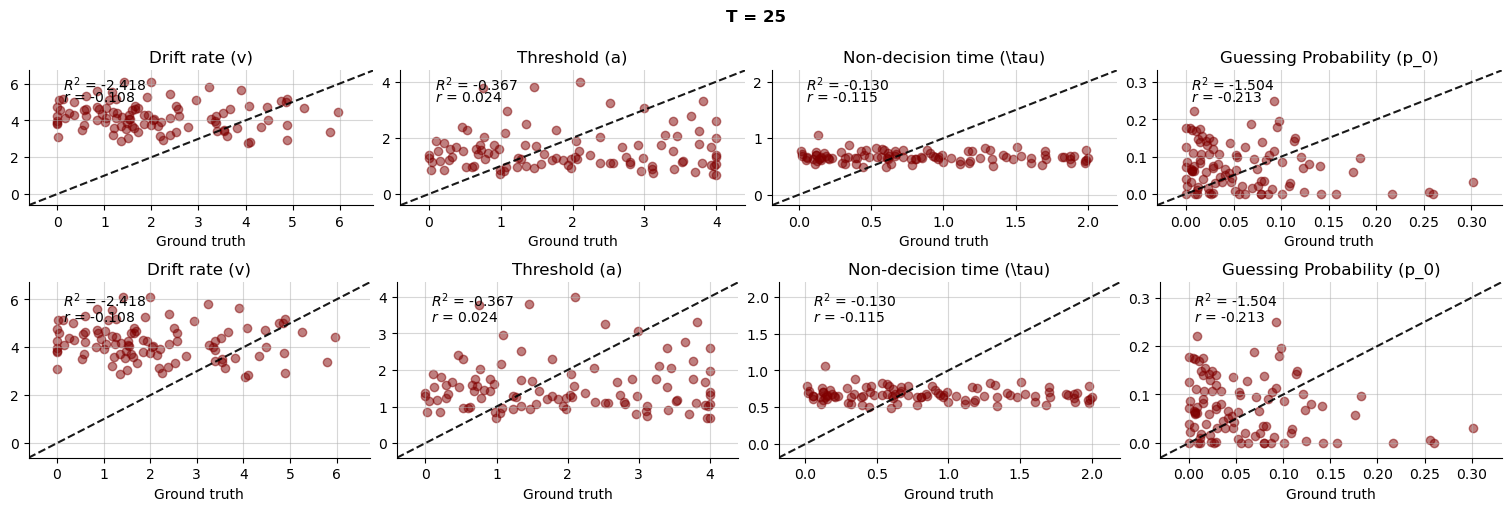

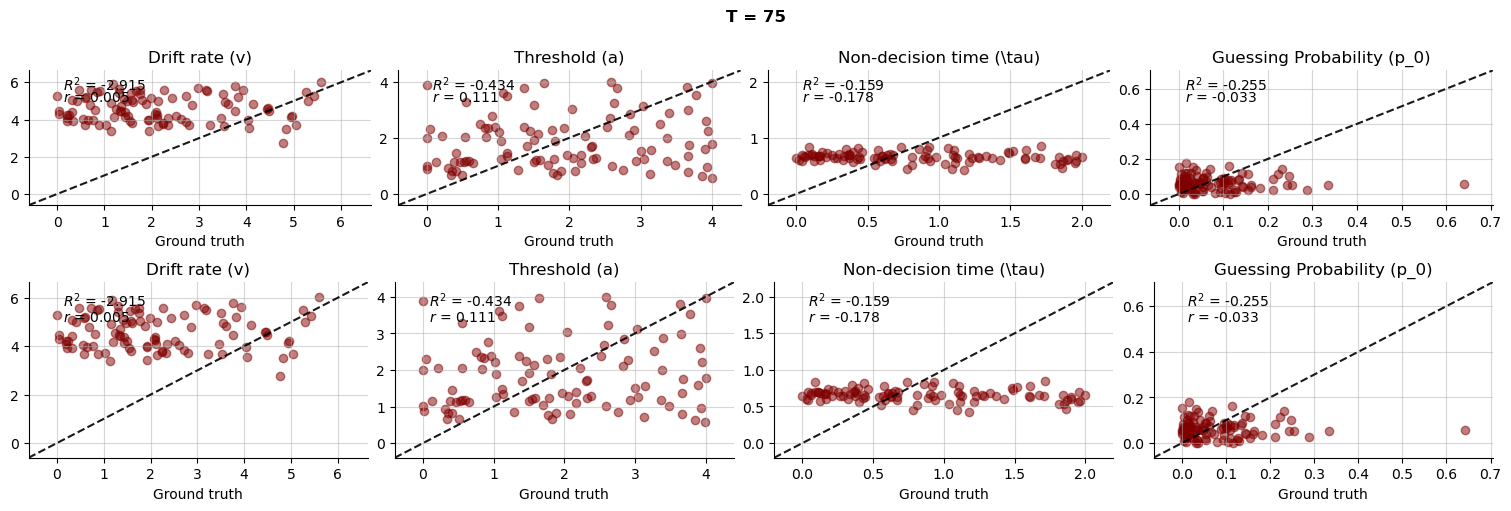

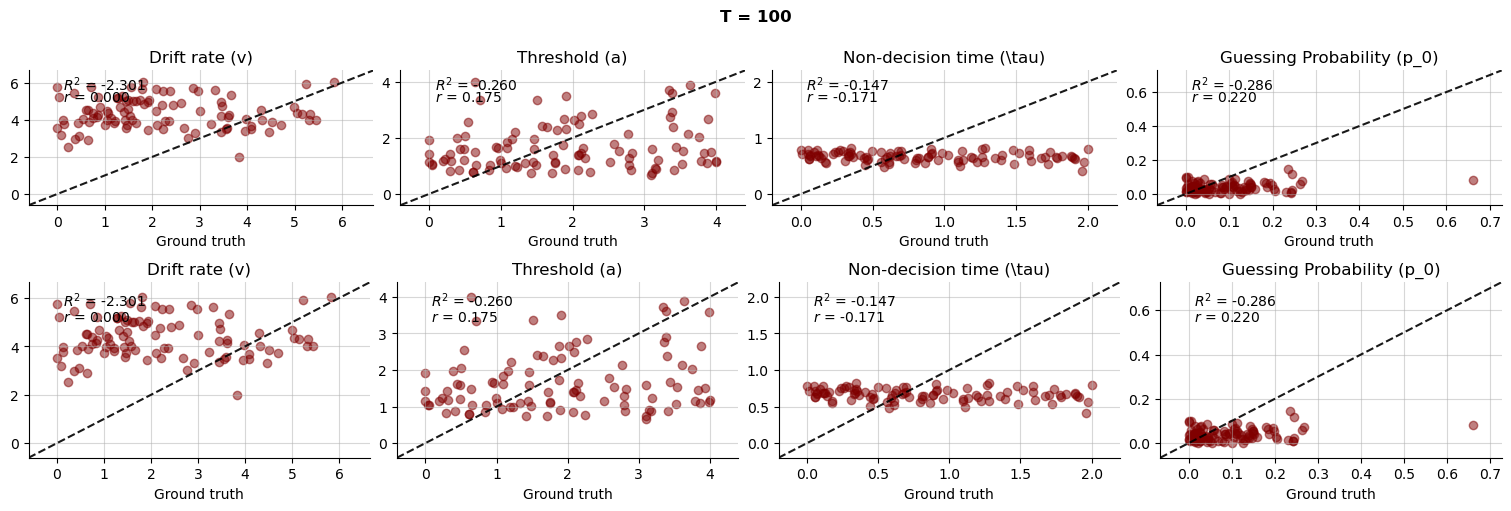

In [227]:
for time_point in TIME_POINTS:

    fig = plt.figure(constrained_layout=True, figsize=(15, 5))

    # create 4x1 subfigs
    subfigs = fig.subfigures(nrows=2, ncols=1)
    for row, subfig in enumerate(subfigs):
        if row == 0:
            subfig.suptitle("T = {}\n".format(time_point + 1), 
                            fontweight='semibold')

        # create 1x4 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=4)
        for col, ax in enumerate(axs):
            ax.scatter(
                true_local_params[:, time_point, col],
                local_post[:, time_point, col],
                alpha=0.5, color="maroon"
                )
            
            # Make plots quadratic to avoid visual illusions
            lower = min(true_local_params[:, time_point, col].min(),
                        local_post[:, time_point, col].min())
            upper = max(true_local_params[:, time_point, col].max(),
                        local_post[:, time_point, col].max())
            eps = (upper - lower) * 0.1
            ax.set_xlim([lower - eps, upper + eps])
            ax.set_ylim([lower - eps, upper + eps])
            ax.plot(
                [ax.get_xlim()[0], ax.get_xlim()[1]],
                [ax.get_ylim()[0], ax.get_ylim()[1]],
                color="black",
                alpha=0.9,
                linestyle="dashed",
            )

            r2 = r2_score(true_local_params[:, time_point, col],
                        local_post[:, time_point, col])
            ax.text(
                0.1, 0.9,
                "$R^2$ = {:.3f}".format(r2),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes
                )
            corr = np.corrcoef(
                true_local_params[:, time_point, col],
                local_post[:, time_point, col]
                )[0, 1]
            ax.text(
                0.1, 0.8,
                "$r$ = {:.3f}".format(corr),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
            )

            ax.set_title(LOCAL_PARAM_LABELS[col] + ' ({})'.format(LOCAL_PARAM_NAMES[col]))
            ax.set_xlabel("Ground truth")
#             if col == 0:
#                 ax.set_ylabel("Estimated")
#                 ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0])
#                 ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0])
#                 if row > 1:
#                     ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
#                     ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
#             if col == 1:
#                 ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0])
#                 ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0])
#             if col == 2:
#                 ax.set_xticks([0.0, 0.5, 1, 1.5])
#                 ax.set_yticks([0.0, 0.5, 1, 1.5])
            # Prettify
            ax.grid(alpha=0.5)
            ax.tick_params(axis="both", which="major")
            ax.tick_params(axis="both", which="minor")

    sns.despine()
    # fig.tight_layout()

#### Parameter Recovery of Hyper Parameters

In [244]:
prior_hyper_samples = configured_sim_data["hyper_parameters"] * model.hyper_prior_std + model.hyper_prior_mean

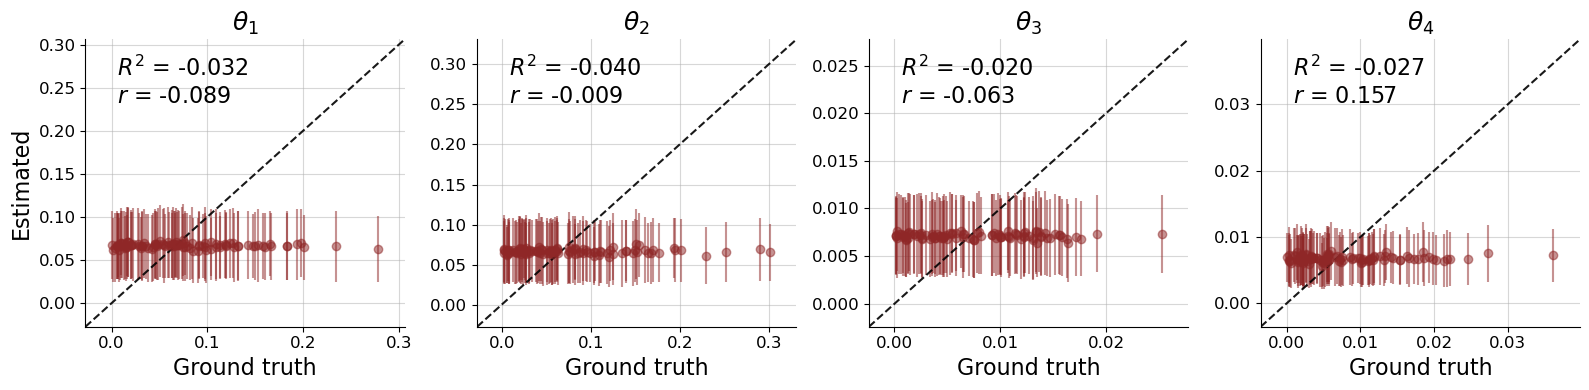

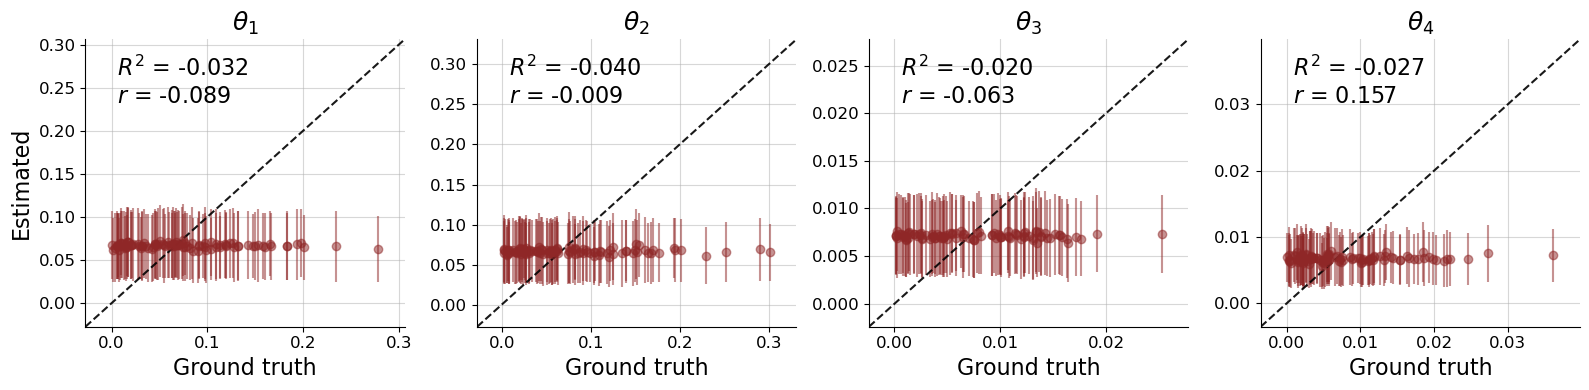

In [245]:
beef.diagnostics.plot_recovery(
    hyper_params,
    prior_hyper_samples
)

#### Parameter Recovery of Shared Parameters

In [230]:
prior_shared_samples = configured_sim_data["shared_parameters"]

C:\Users\selin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\selin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


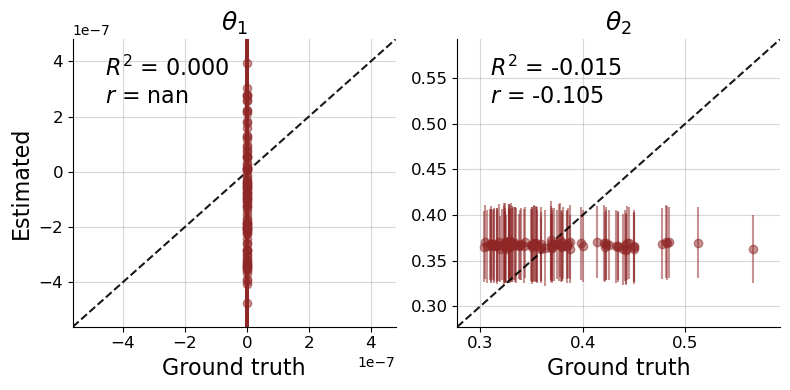

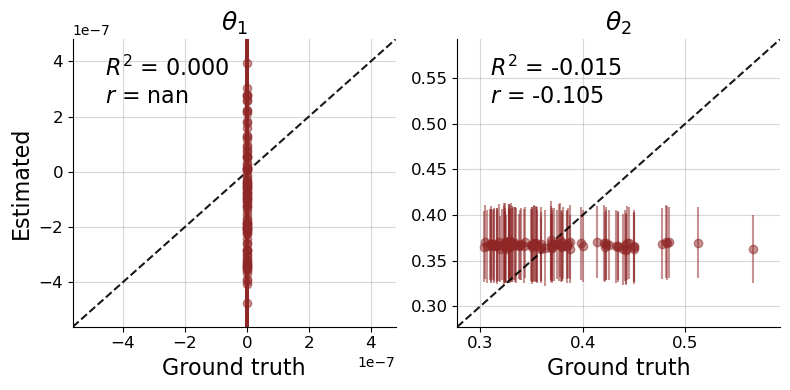

In [231]:
beef.diagnostics.plot_recovery(
    shared_params,
    prior_shared_samples
)

### Prior Pushforward Check

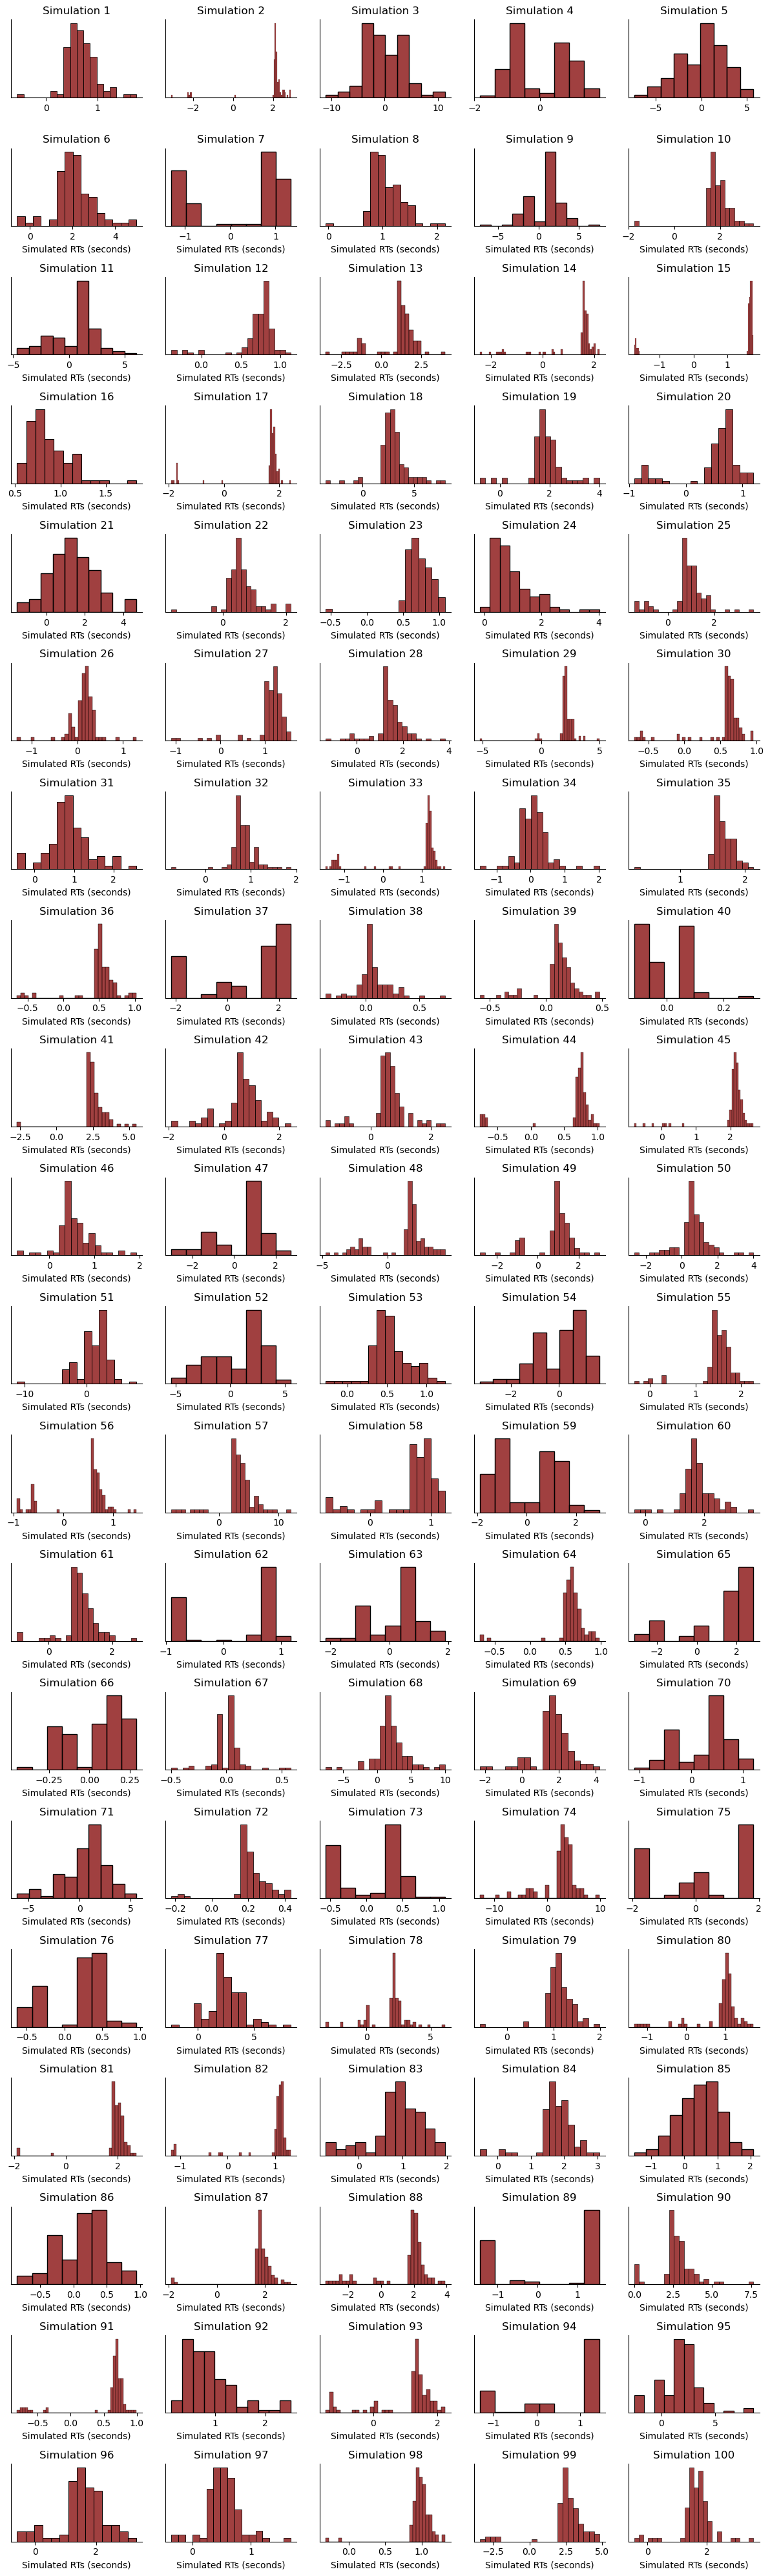

In [232]:
f, axarr = plt.subplots(20, 5, figsize=(12, 40))
for i, ax in enumerate(axarr.flat):
    sns.histplot(sim_data["sim_data"][i, :].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(f"Simulation {i + 1}")
    if i > 4:
        ax.set_xlabel("Simulated RTs (seconds)")
f.tight_layout()

In [235]:
ddm_parameters = sim_data['local_prior_draws'][0]
time_steps = np.arange(ddm_parameters.shape[0])
LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time', 'Probability to Guess']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau', r'p_0']

<bound method Figure.tight_layout of <Figure size 1600x300 with 4 Axes>>

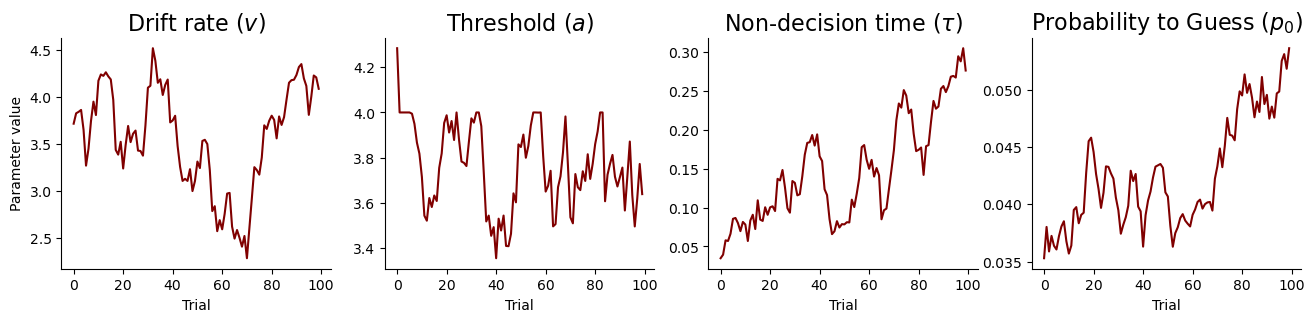

In [236]:
f, axarr = plt.subplots(1, 4, figsize=(16, 3))
for i, ax in enumerate(axarr.flat):
    ax.plot(time_steps, ddm_parameters[:, i], color='maroon')
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=16)
    if i == 0:
        ax.set_ylabel("Parameter value")
    ax.set_xlabel("Trial")
sns.despine()
f.tight_layout

### Prior Predictive Checks

## Evaluation

In [ ]:
data = pd.read_csv("../data/2afc_data.csv")
data["rt"][data["correct"] == 0] = -data["rt"][data["correct"] == 0]

In [ ]:
N_OBS = 80
N_SUB = len(np.unique(data['id']))
N_SAMPLES = 2000
N_RESIM = 200

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']

FONT_SIZE_1 = 18
FONT_SIZE_2 = 16
FONT_SIZE_3 = 12

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [ ]:
if FIT_MODEL:
    post_samples = np.zeros((N_SUB, N_OBS, N_SAMPLES, 3))
    padding = np.full((1, N_SAMPLES, 3), np.nan)
    with tf.device('/cpu:0'):
        for i in range(N_SUB):
            person_data = data[data['id'] == i+1]
            person_data = person_data['rt'].to_numpy()
            nan_idx = np.argwhere(np.isnan(person_data))
            tmp_data = person_data[np.isfinite(person_data)]
            tmp_data = {'summary_conditions': tmp_data[None, ..., None]}
            samples = neural_experiment.amortizer.sample(tmp_data, N_SAMPLES)['local_samples']
            for idx in range(nan_idx.shape[0]):
                start_idx = nan_idx[idx][0]
                samples = np.concatenate(
                    (samples[:start_idx, :, :], padding, samples[start_idx:, :, :]), axis=0
                )
            post_samples[i] = samples
    np.save("../data/posterior_samples.npy", post_samples)
else:
    post_samples = np.load("../data/posterior_samples.npy")

In [ ]:
post_samples_not_z = post_samples * model.local_prior_stds + model.local_prior_means
post_means = np.nanmean(post_samples_not_z, axis=2)
post_means_mean = np.nanmean(post_means, axis=0)
post_means_std = np.nanstd(post_means, axis=0)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 3))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        range(N_OBS), post_means_mean[:, i],
        color='maroon', alpha=0.8
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.3
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.4)

    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_xticks([1, 20, 40, 60, 80])

sns.despine()
f.tight_layout()

plt.savefig('../plots/parameter_dynamic_2afc.png', dpi=300)

## Posterior resimulation

In [ ]:
if POSTERIOR_RESIMULATION:
    pred_data = np.zeros((N_RESIM, N_SUB, N_OBS, 1))
    for s in range(N_SUB):
        post_idx = np.random.choice(np.arange(N_SAMPLES), N_RESIM)
        for i in range(N_RESIM):
            idx = post_idx[i]
            pred_data[i, s] = sample_random_walk_mixture_diffusion_process(post_samples_not_z[s, :, idx])[:, None]
    np.save("../data/posterior_resimulation_hehe_hetero.npy", pred_data)
else:
    pred_data = np.load("../data/posterior_resimulation_hehe_hetero.npy")